# Get data

In [7]:
import pandas as pd
import os
from tqdm import tqdm
import json

In [8]:
REVIEW_PATH = '../Resources/1_clean_review_data'

KEYWORDS_PATH = '../Resources/2_keywords_for_teams_data'

DATA_PATH = '../Resources'

REVIEW_COL = 'Review'
TITLE_COL = 'Title'

In [9]:
data = pd.read_csv(os.path.join(REVIEW_PATH,'cleanAppStore.csv'))

In [102]:
with open(os.path.join(KEYWORDS_PATH,'team_keywords.json'),'r') as f:
    team_names_keywords = json.load(f)

with open(os.path.join(KEYWORDS_PATH,'grouped_team_keywords.json'),'r') as f:
    groups_keywords = json.load(f)
    
with open(os.path.join(KEYWORDS_PATH,'grouped_team_mapping.json'),'r') as f:
    mapping = json.load(f)

In [110]:
team_names_keywords_vects = [' '.join(team_names_keywords[team]) for team in team_names_keywords]
group_names_keywords_vects = [' '.join(groups_keywords[team]) for team in groups_keywords]

# Create embeddings

## Flair embeddings

In [193]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

# initialize the word embeddings
glove_embedding = WordEmbeddings('ru')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding])

2020-08-01 16:37:37,315 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4/ru-wiki-fasttext-300d-1M.vectors.npy not found in cache, downloading to /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmp4iome7_k


100%|██████████| 1199998928/1199998928 [04:05<00:00, 4883986.73B/s]

2020-08-01 16:41:43,352 copying /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmp4iome7_k to cache at /Users/Alisa.Alenicheva/.flair/embeddings/ru-wiki-fasttext-300d-1M.vectors.npy


2020-08-01 16:41:44,792 removing temp file /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmp4iome7_k
2020-08-01 16:41:45,101 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4/ru-wiki-fasttext-300d-1M not found in cache, downloading to /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmpvg4ycc_u


100%|██████████| 47974727/47974727 [00:09<00:00, 5082572.09B/s]

2020-08-01 16:41:54,822 copying /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmpvg4ycc_u to cache at /Users/Alisa.Alenicheva/.flair/embeddings/ru-wiki-fasttext-300d-1M
2020-08-01 16:41:54,872 removing temp file /var/folders/pd/dd4z8dyj3kq83yh_y3_xmrlw0000kt/T/tmpvg4ycc_u


In [194]:
from flair.data import Sentence

In [195]:
import string
def text_embeddings(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    
#     from rutermextract import TermExtractor
#     term_extractor = TermExtractor()
#     tokens = ' '.join([term.normalized for term in term_extractor(text)])
    sentence = Sentence(text)
    document_embeddings.embed(sentence)
    return sentence.embedding.numpy()

In [196]:
X_train = []
for i in tqdm(data.index):
    text = data.iloc[i][REVIEW_COL]+' '+data.iloc[i][TITLE_COL]
    X_train.append(text_embeddings(text))

100%|██████████| 11584/11584 [00:09<00:00, 1276.52it/s]


In [197]:
teams_vecs = []
for team in tqdm(team_names_keywords_vects):
    teams_vecs.append(text_embeddings(team))

100%|██████████| 42/42 [00:00<00:00, 3005.80it/s]


In [198]:
groups_vecs = []
for team in tqdm(group_names_keywords_vects):
    groups_vecs.append(text_embeddings(team))

100%|██████████| 26/26 [00:00<00:00, 2519.63it/s]


### Clusterization

### Calculate optimal clusters number with Elbow alg

100%|██████████| 49/49 [02:00<00:00,  2.46s/it]


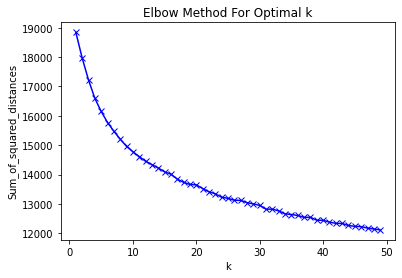

In [199]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,50)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [230]:
km = KMeans(n_clusters=10)
km = km.fit(X_train)

In [225]:
from sklearn.decomposition import PCA

In [226]:
pca = PCA(n_components=2, random_state=2)
reduced_features = pca.fit_transform(X_train)

In [227]:
reduced_cluster_centers = pca.transform(km.cluster_centers_)

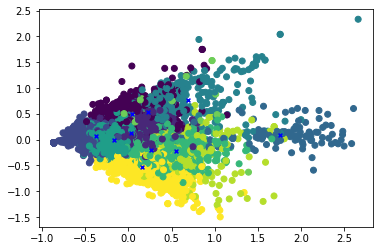

In [228]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(X_train))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=15, c='b')

In [205]:
df_clusters = pd.DataFrame(columns=['team','cluster'])

In [206]:
df_clusters['team'] = team_names_keywords.keys()
df_clusters['cluster'] = km.predict(teams_vecs)

In [207]:
df_reviews = pd.DataFrame(columns=['review','cluster'])

In [208]:
df_reviews['review'] = data[REVIEW_COL]
df_reviews['cluster'] = km.predict(X_train)

In [210]:
import random

#### Sample reviews from each cluster

In [211]:
from collections import Counter
counter = Counter(km.labels_)
for cluster_num in range(5):
    sampling = random.choices(list(df_reviews[df_reviews['cluster']==cluster_num]['review']), k=20)
    print('Cluster: ', cluster_num)
    print('Reviews')
    print('\n'.join(sampling))

Cluster:  0
Reviews
Одно не устраивает что берет камисию за платежи жкх
Слишком много комиссий. Даже личный телефон оплачивается с комиссией,штрафы с комиссией... позор и ужас
Хотел перевести деньги из «Цели» на карту, но эти «Цели» размножились, как Доктор Стрэндж. Выбираю одну из них, а там на балансе 0₽, считай, не угадал. Это норма? Или с этим можно что-то сделать?
Самый лучший банк))нравится все, и услуги, и интерфейс.
Спасибо сотруднику Зеленковой Екатерине город Санкт-Петербург.
Дело решалось банальной переустановкой. Но за почти 270 Мб сожранного мобильного трафика, за просто так минус одна звёздочка
Ничего не исправили при обновлении! Вообще зайти не могу. 
Говорят что знают о проблеме, но видимо решить не получается.
Сделайте lite версию только для переводов без лишних функций.
Сбои в платежах
Я даже не представляю Как можно было так испортить приложение в части отображения и выбора всего, что связано с карточными продуктами.
Просмотренные push-уведомления через какое-то врем

### Create embedding predictions

#### Teams predictions

In [231]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity


predictions_list = []
j = 0
for review in tqdm(X_train):
    predictions = {}
    predictions['review'] = data.iloc[j][REVIEW_COL]
    destinations = {}
    for i,team in enumerate(teams_vecs):
        dest = euclidean_distances([review], [team])[0]
        destinations[list(team_names_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1]))
    predictions['euclid_team'] = list(scores.keys())[0]
    predictions['euclid_score'] = scores[list(scores.keys())[0]]

    
    destinations = {}
    for i,team in enumerate(teams_vecs):
        dest = cosine_similarity([review], [team])[0]
        destinations[list(team_names_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1],reverse=True))
    predictions['cosine_team'] = list(scores.keys())[0]
    predictions['cosine_score'] = scores[list(scores.keys())[0]]
    predictions_list.append(predictions)
    j+=1

100%|██████████| 11584/11584 [02:53<00:00, 66.94it/s]


In [213]:
predictions_df = pd.DataFrame(predictions_list)

In [214]:
predictions_df['euclid_team'].value_counts()

Sberbank ID B2C                                             7120
СБОЛ. Классические переводы                                 2170
iOS Platform                                                1682
ЕФС.Платежи МП                                               153
Global Navigation                                            145
Мессенджер                                                   111
Текстовый чат                                                 72
[ЕФС].Кредитные карты.Космонавты (Доп. услуги и сервисы)      52
ЕФС.Автоплатежи                                               19
PUSH IOS                                                      12
Развитие лояльности в МП СБОЛ                                 11
ПДВ в Digital                                                 10
Дебетовые карты в мобильном приложении                         7
iOS Release Engineer                                           6
Платежи. Штрафы                                                4
Плановый и досрочный пере

In [215]:
predictions_df['cosine_team'].value_counts()

iOS Platform                                                4850
СБОЛ. Классические переводы                                 4070
ЕФС.Платежи МП                                               677
Global Navigation                                            284
Текстовый чат                                                256
Развитие лояльности в МП СБОЛ                                236
ЕФС.Автоплатежи                                              161
Sberbank ID B2C                                              160
iOS Release Engineer                                         154
Карта в телефоне                                             110
PUSH IOS                                                      99
[ЕФС].Кредитные карты.Космонавты (Доп. услуги и сервисы)      85
Мессенджер                                                    75
Платежи. Штрафы                                               56
DBP.Витрины продаж                                            39
Дебетовые карты в мобильн

In [216]:
predictions_df[predictions_df['euclid_team']==predictions_df['cosine_team']]['euclid_team'].value_counts()

iOS Platform                                                1512
СБОЛ. Классические переводы                                 1365
Sberbank ID B2C                                              160
Global Navigation                                            129
ЕФС.Платежи МП                                               103
Текстовый чат                                                 61
Мессенджер                                                    44
[ЕФС].Кредитные карты.Космонавты (Доп. услуги и сервисы)      26
ЕФС.Автоплатежи                                               18
Развитие лояльности в МП СБОЛ                                 11
PUSH IOS                                                      11
ПДВ в Digital                                                  9
Дебетовые карты в мобильном приложении                         7
iOS Release Engineer                                           6
Платежи. Штрафы                                                4
ВС.МП вклады             

In [232]:
predictions_df.to_csv('../Resources/teams_predictions_flair.csv')

#### Teams predictions

In [219]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity


predictions_list = []
j = 0
for review in tqdm(X_train):
    predictions = {}
    predictions['review'] = data.iloc[j][REVIEW_COL]
    destinations = {}
    for i,team in enumerate(groups_vecs):
        dest = euclidean_distances([review], [team])[0]
        destinations[list(groups_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1]))
    predictions['euclid_team'] = list(scores.keys())[0]
    predictions['euclid_score'] = scores[list(scores.keys())[0]]

    
    destinations = {}
    for i,team in enumerate(groups_vecs):
        dest = cosine_similarity([review], [team])[0]
        destinations[list(groups_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1],reverse=True))
    predictions['cosine_team'] = list(scores.keys())[0]
    predictions['cosine_score'] = scores[list(scores.keys())[0]]
    predictions_list.append(predictions)
    j+=1

100%|██████████| 11584/11584 [01:52<00:00, 102.58it/s]


In [220]:
predictions_df_groups = pd.DataFrame(predictions_list)

In [221]:
predictions_df_groups.to_csv('../Resources/groups_predictions_flair.csv')

In [222]:
predictions_df_groups['euclid_team'].value_counts()

Sberbank ID B2C                  4706
платежи                          2655
интерфейс приложения             2496
общение                          1660
кредит                             23
фигня                              13
операции с картами                 12
PUSH IOS                            8
Развитие лояльности в МП СБОЛ       7
ВС.МП вклады                        2
История операций                    1
PFM Бюджет                          1
Name: euclid_team, dtype: int64

In [223]:
predictions_df_groups['cosine_team'].value_counts()

интерфейс приложения             6103
платежи                          3615
общение                           959
Развитие лояльности в МП СБОЛ     219
кредит                            112
Карта в телефоне                  109
Sberbank ID B2C                    84
фигня                              82
PUSH IOS                           78
операции с картами                 59
DBP.Витрины продаж                 30
PFM Бюджет                         21
Редактируемый профиль клиента      21
ЕФС Выписки и справки. Mobile      19
История операций                   15
данные клиента                     12
ВС.МП вклады                       11
Автопереводы                       10
DDA Profile                        10
ЕФС. Брокеридж. Мобайл              7
ЕФС. Страхование                    5
PFM                                 3
Name: cosine_team, dtype: int64

## BERT

In [123]:
from sentence_transformers import SentenceTransformer, util

In [124]:
embedder = SentenceTransformer('distiluse-base-multilingual-cased')

100%|██████████| 504M/504M [01:42<00:00, 4.93MB/s] 


In [125]:
corpus = data[REVIEW_COL]

In [126]:
corpus_embeddings = embedder.encode(corpus)

In [234]:
teams_vecs = embedder.encode(team_names_keywords_vects)


In [128]:
groups_vecs = embedder.encode(group_names_keywords_vects)

### Compute optimal number of clusters

100%|██████████| 49/49 [02:47<00:00,  3.43s/it]


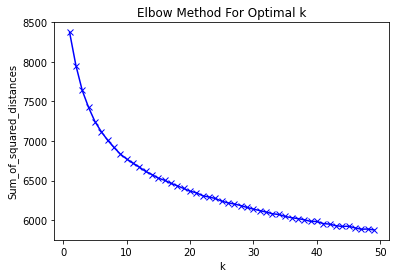

In [129]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,50)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(corpus_embeddings)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [152]:
km = KMeans(n_clusters=6)
km = km.fit(corpus_embeddings)

In [153]:
from sklearn.decomposition import PCA

In [154]:
pca = PCA(n_components=2, random_state=2)
reduced_features = pca.fit_transform(corpus_embeddings)

In [155]:
reduced_cluster_centers = pca.transform(km.cluster_centers_)

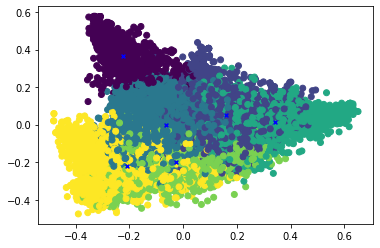

In [156]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(corpus_embeddings))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=15, c='b')

In [157]:
df_clusters = pd.DataFrame(columns=['team','cluster'])

In [158]:
df_clusters['team'] = team_names_keywords.keys()
df_clusters['cluster'] = km.predict(teams_vecs)

In [159]:
df_reviews = pd.DataFrame(columns=['review','cluster'])

In [161]:
df_reviews['review'] = data[REVIEW_COL]
df_reviews['cluster'] = km.predict(corpus_embeddings)

### Sample reviews from each cluster

In [163]:
from collections import Counter
counter = Counter(km.labels_)
for cluster_num in range(5):
    sampling = random.choices(list(df_reviews[df_reviews['cluster']==cluster_num]['review']), k=20)
    print('Cluster: ', cluster_num)
    print('Reviews')
    print('\n'.join(sampling))

Cluster:  0
Reviews
Süper
Все хорошо,спасибо
Спасибо за все! Просто молодцы!
Спасибочки большое
Одобно!!!!
Все чётко
Удобно. Комфортно. Качественно.
Удобно, быстро!!!
Зависает по страшному 🤦‍♂️
Вы самые лучшие
Спасибо большое всё правильно и своевременно!!!
Все прекрасно настройке функции 👌
Тормозит
Отличный!
Очень удобно
спасибо
Исправьте
Быстро. Надежно!!!

Голова
Обслуживание на отлично!!! Благодарю!
Все отлично!!!
Cluster:  1
Reviews
Отличное приложение !
Все нравится,отличное приложение,спасибо разработчикам.
Было бы лучше если приложения бы работало без интернета
Дизайнеры постарались, скопировали приложение Тинькова и раскрасили в брендовые цвета сбера :)
Приложение очень сильно лагает, а в остальном все хорошо.
Каждый раз при входе в приложение загрузка прекращается на экране приветствия!!! Приходится выходить и заходить снова !
Удобное и понятное приложение.
Хотелось бы ещё в мобильном приложении видеть, от каких операций начислились и куда списались бонусы Спасибо.
Уже под 30

#### Predictions for teams

In [235]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity


predictions_list = []
j = 0
for review in tqdm(corpus_embeddings):
    predictions = {}
    predictions['review'] = data.iloc[j][REVIEW_COL]
    destinations = {}
    for i,team in enumerate(teams_vecs):
        dest = euclidean_distances([review], [team])[0]
        destinations[list(team_names_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1]))
    predictions['euclid_team'] = list(scores.keys())[0]
    predictions['euclid_score'] = scores[list(scores.keys())[0]]

    
    destinations = {}
    for i,team in enumerate(teams_vecs):
        dest = cosine_similarity([review], [team])[0]
        destinations[list(team_names_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1],reverse=True))
    predictions['cosine_team'] = list(scores.keys())[0]
    predictions['cosine_score'] = scores[list(scores.keys())[0]]
    predictions_list.append(predictions)
    j+=1

100%|██████████| 11584/11584 [02:55<00:00, 65.89it/s]


In [236]:
predictions_df = pd.DataFrame(predictions_list)
predictions_df.to_csv('../Resources/teams_predictions_bert.csv')

In [166]:
predictions_df['euclid_team'].value_counts()

iOS Platform                                                2101
iOS Release Engineer                                         853
Развитие лояльности в МП СБОЛ                                824
Госуслуги                                                    800
СБОЛ. Классические переводы                                  775
Самозанятые                                                  596
DBP.Витрины продаж                                           533
Краудфандинг                                                 476
Дебетовые карты в мобильном приложении                       471
Комиссионные продукты                                        398
Телеком                                                      389
Плановый и досрочный перевыпуск дебетовых карт               349
Текстовый чат                                                320
Платежи. Штрафы                                              249
Global Navigation                                            234
ПДВ в Digital            

#### Predictions for groups

In [169]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity


predictions_list = []
j = 0
for review in tqdm(corpus_embeddings):
    predictions = {}
    predictions['review'] = data.iloc[j][REVIEW_COL]
    destinations = {}
    for i,team in enumerate(groups_vecs):
        dest = euclidean_distances([review], [team])[0]
        destinations[list(groups_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1]))
    predictions['euclid_team'] = list(scores.keys())[0]
    predictions['euclid_score'] = scores[list(scores.keys())[0]]

    
    destinations = {}
    for i,team in enumerate(groups_vecs):
        dest = cosine_similarity([review], [team])[0]
        destinations[list(groups_keywords.keys())[i]] = dest
    scores = OrderedDict(sorted(destinations.items(), key=lambda kv: kv[1],reverse=True))
    predictions['cosine_team'] = list(scores.keys())[0]
    predictions['cosine_score'] = scores[list(scores.keys())[0]]
    predictions_list.append(predictions)
    j+=1

100%|██████████| 11584/11584 [01:54<00:00, 100.80it/s]


In [170]:
predictions_df_groups = pd.DataFrame(predictions_list)

In [171]:
predictions_df_groups.to_csv('../Resources/groups_predictions_bert.csv')

In [172]:
predictions_df_groups

,review,euclid_team,euclid_score,cosine_team,cosine_score
0,Не скачивается стала обновлять и зависло прило...,интерфейс приложения,[1.1439611],Sberbank ID B2C,[0.22501919]
1,Приложение не открывается после обновления!!!!...,интерфейс приложения,[1.1276852],интерфейс приложения,[0.21633334]
2,"Добрый день, после последнего обновления пропа...",данные клиента,[1.1680582],данные клиента,[0.20235847]
3,Не могу скачать так как требует подключения Wi-fi,интерфейс приложения,[1.1426462],интерфейс приложения,[0.14617676]
4,Почему то не могу оплатить при минусе на балан...,Карта в телефоне,[1.0712026],Карта в телефоне,[0.34158123]
...,...,...,...,...,...
11579,Благодарю Сбербанк за четкую и оперативную раб...,фигня,[1.0881823],фигня,[0.34577796]
11580,Зачем вы все время усложняете приложение. Выки...,платежи,[1.155893],фигня,[0.17719087]
11581,Вы просто супер,Госуслуги,[1.1250776],Госуслуги,[0.16617933]
11582,Молодцы! Лучшее банковское приложение!\nСделай...,DBP.Витрины продаж,[1.0684865],DBP.Витрины продаж,[0.30081087]


In [174]:
predictions_df_groups['euclid_team'].value_counts()

интерфейс приложения             2773
платежи                          1880
Госуслуги                        1115
Самозанятые                       998
операции с картами                935
DBP.Витрины продаж                896
Развитие лояльности в МП СБОЛ     889
общение                           371
PUSH IOS                          224
Автопереводы                      217
ЕФС. Брокеридж. Мобайл            211
PFM Бюджет                        181
Sberbank ID B2C                   160
ЕФС Выписки и справки. Mobile     151
История операций                  140
кредит                             89
ВС.МП вклады                       88
Редактируемый профиль клиента      60
DDA Profile                        32
Карта в телефоне                   31
инвестиции                         31
ЕФС. Страхование                   30
данные клиента                     29
фигня                              27
PFM                                26
Name: euclid_team, dtype: int64